# Residual Networks


This notebook has been made according to course from Andrew Ng <b>TODO DODELAT!!!</b>

Welcome to the first assignment of this week! You'll be building a very deep convolutional network, using Residual Networks (ResNets). In theory, very deep networks can represent very complex functions; but in practice, they are hard to train. Residual Networks, introduced by [He et al.](https://arxiv.org/pdf/1512.03385.pdf), allow you to train much deeper networks than were previously feasible.

**By the end of this assignment, you'll be able to:**

- Implement the basic building blocks of ResNets in a deep neural network using Keras
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification
- Implement a skip connection in your network

For this assignment, you'll use Keras. 

Before jumping into the problem, run the cell below to load the required packages.

## Table of Content

- [1 - Packages](#1)
- [2 - The Problem of Very Deep Neural Networks](#2)
- [3 - Building a Residual Network](#3)
    - [3.1 - The Identity Block](#3-1)
        - [Exercise 1 - identity_block](#ex-1)
    - [3.2 - The Convolutional Block](#3-2)
        - [Exercise 2 - convolutional_block](#ex-2)
- [4 - Building Your First ResNet Model (50 layers)](#4)
    - [Exercise 3 - ResNet50](#ex-3)
- [5 - Test on Your Own Image (Optional/Ungraded)](#5)
- [6 - Bibliography](#6)

<a name='1'></a>
## 1 - Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


%matplotlib inline
np.random.seed(1)

<a name='2'></a>
## 2 - The Problem of Very Deep Neural Networks

Last week, you built your first convolutional neural networks: first manually with numpy, then using Tensorflow and Keras. 

In recent years, neural networks have become much deeper, with state-of-the-art networks evolving from having just a few layers (e.g., AlexNet) to over a hundred layers.

* The main benefit of a very deep network is that it can represent very complex functions. It can also learn features at many different levels of abstraction, from edges (at the shallower layers, closer to the input) to very complex features (at the deeper layers, closer to the output). 

* However, using a deeper network doesn't always help. A huge barrier to training them is vanishing gradients: very deep networks often have a gradient signal that goes to zero quickly, thus making gradient descent prohibitively slow.

* More specifically, during gradient descent, as you backpropagate from the final layer back to the first layer, you are multiplying by the weight matrix on each step, and thus the gradient can decrease exponentially quickly to zero (or, in rare cases, grow exponentially quickly and "explode," from gaining very large values). 

* During training, you might therefore see the magnitude (or norm) of the gradient for the shallower layers decrease to zero very rapidly as training proceeds, as shown below: 

<img src="./images/vanishing_grad_kiank.png" style="width:450px;height:220px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u><font color='purple'>  : <b>Vanishing gradient</b> <br> The speed of learning decreases very rapidly for the shallower layers as the network trains </center></caption>

Not to worry! You are now going to solve this problem by building a Residual Network!

<a name='3'></a>
## 3 - Building a Residual Network

In ResNets, a "shortcut" or a "skip connection" allows the model to skip layers:  

<img src="images/skip_connection_kiank.png" style="width:650px;height:200px;">
<caption><center> <u> <font color='purple'> <b>Figure 2</b> </u><font color='purple'>  : A ResNet block showing a skip-connection <br> </center></caption>

The image on the left shows the "main path" through the network. The image on the right adds a shortcut to the main path. By stacking these ResNet blocks on top of each other, you can form a very deep network. 

The lecture mentioned that having ResNet blocks with the shortcut also makes it very easy for one of the blocks to learn an identity function. This means that you can stack on additional ResNet blocks with little risk of harming training set performance.  
    
On that note, there is also some evidence that the ease of learning an identity function accounts for ResNets' remarkable performance even more than skip connections help with vanishing gradients.

Two main types of blocks are used in a ResNet, depending mainly on whether the input/output dimensions are the same or different. You are going to implement both of them: the "identity block" and the "convolutional block."

<a name='3-1'></a>
### 3.1 - The Identity Block

The identity block is the standard block used in ResNets, and corresponds to the case where the input activation (say $a^{[l]}$) has the same dimension as the output activation (say $a^{[l+2]}$). To flesh out the different steps of what happens in a ResNet's identity block, here is an alternative diagram showing the individual steps:

<img src="images/idblock2_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 3</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 2 layers. </center></caption>

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, notice the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added. Don't worry about this being complicated to implement--you'll see that BatchNorm is just one line of code in Keras! 

In this exercise, you'll actually implement a slightly more powerful version of this identity block, in which the skip connection "skips over" 3 hidden layers rather than 2 layers. It looks like this: 

<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">
    <caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Identity block.</b> Skip connection "skips over" 3 layers.</center></caption>

These are the individual steps:

First component of main path: 
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape $(f,f)$ and a stride of (1,1). Its padding is "same". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters.

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid". Use 0 as the seed for the random uniform initialization: `kernel_initializer = initializer(seed=0)`. 
- The third BatchNorm is normalizing the 'channels' axis.
- Note that there is **no** ReLU activation function in this component. 

Final step: 
- The `X_shortcut` and the output from the 3rd layer `X` are added together.
- **Hint**: The syntax will look something like `Add()([var1,var2])`
- Then apply the ReLU activation function. This has no hyperparameters. 

<a name='ex-1'></a>
### Exercise 1 - identity_block

Implement the ResNet identity block. The first component of the main path has been implemented for you already! First, you should read these docs carefully to make sure you understand what's happening. Then, implement the rest. 
- To implement the Conv2D step: [Conv2D](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/Conv2D)
- To implement BatchNorm: [BatchNormalization](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/BatchNormalization) `BatchNormalization(axis = 3)(X)`. If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
- For the activation, use:  `Activation('relu')(X)`
- To add the value passed forward by the shortcut: [Add](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/Add)

We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package [tensorflow.keras.initializers](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/initializers) or any other custom initializer. By default it will be set to [random_uniform](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/initializers/RandomUniform)

Remember that these functions accept a `seed` argument that can be any value you want, but that in this notebook must set to 0 for **grading purposes**.

In [2]:
# Code of identity block
class IdentityBlock(nn.Module):
    def __init__(self, input_channel , kernel_size, filters, padding):
        super().__init__()
        f1, f2, f3 = filters
        self.conv2d_1x1 =  nn.Conv2d(in_channels=input_channel, 
                                 out_channels = f1, 
                                 kernel_size =1, 
                                 stride = 1, 
                                 padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(self.conv2d_1x1.out_channels)
        self.conv2d_nxn =  nn.Conv2d(in_channels=self.conv2d_1x1.out_channels, 
                                 out_channels = f2, 
                                 kernel_size =kernel_size, 
                                 stride = 1, 
                                 padding = padding)
        self.batchnorm2 = nn.BatchNorm2d(self.conv2d_nxn.out_channels)
        self.conv2d_1x1_2 =  nn.Conv2d(in_channels=self.conv2d_nxn.out_channels, 
                                 out_channels = f3, 
                                 kernel_size =1, 
                                 stride = 1, 
                                 padding = 0)
        self.batchnorm3 = nn.BatchNorm2d(self.conv2d_1x1_2.out_channels)
        self.relu = torch.nn.ReLU(inplace=False)

    def forward(self, input):
        # Stage 1
        x = self.conv2d_1x1(input)
        x = self.batchnorm1(x)
        x = self.relu(x)
        # Stage 2
        x = self.conv2d_nxn(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        # Stage 3
        x = self.conv2d_1x1_2(x)
        x = self.batchnorm3(x)
        # Add
        x = torch.add(x,input)
        x = self.relu(x)
        return x

In [3]:
dummy_input = torch.randn(1, 256, 32, 32) # (N,Channels,Height​,Width​) 
# Test of identity code block
IB = IdentityBlock(input_channel=256, kernel_size=3, filters=[64,64,256], padding = 1)
IB.forward(dummy_input).shape

torch.Size([1, 256, 32, 32])

<a name='3-2'></a>
### 3.2 - The Convolutional Block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path: 

<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 4</b> </u><font color='purple'>  : <b>Convolutional block</b> </center></caption>

* The CONV2D layer in the shortcut path is used to resize the input $x$ to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix $W_s$ discussed in lecture.) 
* For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. 
* The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step. 
* As for the previous exercise, the additional `initializer` argument is required for grading purposes, and it has been set by default to [glorot_uniform](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/initializers/GlorotUniform)

The details of the convolutional block are as follows. 

First component of main path:
- The first CONV2D has $F_1$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid". Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The first BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Second component of main path:
- The second CONV2D has $F_2$ filters of shape (f,f) and a stride of (1,1). Its padding is "same".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The second BatchNorm is normalizing the 'channels' axis.
- Then apply the ReLU activation function. This has no hyperparameters. 

Third component of main path:
- The third CONV2D has $F_3$ filters of shape (1,1) and a stride of (1,1). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The third BatchNorm is normalizing the 'channels' axis. Note that there is no ReLU activation function in this component. 

Shortcut path:
- The CONV2D has $F_3$ filters of shape (1,1) and a stride of (s,s). Its padding is "valid".  Use 0 as the `glorot_uniform` seed `kernel_initializer = initializer(seed=0)`.
- The BatchNorm is normalizing the 'channels' axis. 

Final step: 
- The shortcut and the main path values are added together.
- Then apply the ReLU activation function. This has no hyperparameters. 
 
<a name='ex-2'></a>    
### Exercise 2 - convolutional_block
    
Implement the convolutional block. The first component of the main path is already implemented; then it's your turn to implement the rest! As before, always use 0 as the seed for the random initialization, to ensure consistency with the grader.
- [Conv2D](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/Conv2D)
- [BatchNormalization](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the features axis)) `BatchNormalization(axis = 3)(X)`. If training is set to False, its weights are not updated with the new examples. I.e when the model is used in prediction mode.
- For the activation, use:  `Activation('relu')(X)`
- [Add](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/Add)
    
We have added the initializer argument to our functions. This parameter receives an initializer function like the ones included in the package [tensorflow.keras.initializers](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/initializers) or any other custom initializer. By default it will be set to [glorot_uniform](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/initializers/GlorotUniform)

Remember that these functions accept a `seed` argument that can be any value you want, but that in this notebook must set to 0 for **grading purposes**.

In [4]:
# Code of convolutional block
class ConvolutionalBlock(nn.Module):
    def __init__(self, input_channel , kernel_size, filters, stride, padding):
        super().__init__()
        f1, f2, f3 = filters
        # Stage 1
        self.conv2d_1x1 =  nn.Conv2d(in_channels=input_channel, 
                                 out_channels = f1, 
                                 kernel_size =1, 
                                 stride = (stride, stride), 
                                 padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(self.conv2d_1x1.out_channels)
        # Stage 2
        self.conv2d_nxn =  nn.Conv2d(in_channels=self.conv2d_1x1.out_channels, 
                                 out_channels = f2, 
                                 kernel_size =kernel_size, 
                                 stride = (1,1), 
                                 padding = (padding, padding))
        self.batchnorm2 = nn.BatchNorm2d(self.conv2d_nxn.out_channels)
        # Stage 3
        self.conv2d_1x1_2 =  nn.Conv2d(in_channels=self.conv2d_nxn.out_channels, 
                                 out_channels = f3, 
                                 kernel_size =1, 
                                 stride = 1, 
                                 padding = 0)
        self.batchnorm3 = nn.BatchNorm2d(self.conv2d_1x1_2.out_channels)
        # Stage 4
        self.conv2d_1x1_3 =  nn.Conv2d(in_channels=input_channel, 
                                 out_channels = f3, 
                                 kernel_size =1, 
                                 stride = (stride, stride), 
                                 padding = 0)
        self.batchnorm4 = nn.BatchNorm2d(self.conv2d_1x1_3.out_channels)
        # Activation function
        self.relu = torch.nn.ReLU(inplace=False)

    def forward(self, input):
        # Stage 1
        x = self.conv2d_1x1(input)
        x = self.batchnorm1(x)
        x = self.relu(x)
        # Stage 2
        x = self.conv2d_nxn(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        # Stage 3
        x = self.conv2d_1x1_2(x)
        x = self.batchnorm3(x)
        # Stage 4
        input = self.conv2d_1x1_3(input)
        input = self.batchnorm4(input)        
        # Add
        
        x = torch.add(x,input)
        x = self.relu(x)
        return x

In [5]:
# Test of convolutional code block
dummy_input = torch.randn(1, 64, 32, 32) # (N,Channels,Height​,Width​) 
# Test of identity code block
IB = ConvolutionalBlock(input_channel=64, kernel_size=3, filters=[64,64,256],stride =1, padding = 1)
IB.forward(dummy_input).shape

torch.Size([1, 256, 32, 32])

In [6]:
# Test of convolutional code block
dummy_input = torch.randn(1, 64, 64, 64) # (N,Channels,Height​,Width​) 
# Test of identity code block
IB = ConvolutionalBlock(input_channel=64, kernel_size=3, filters=[64,64,256],stride =2, padding = 1)
IB.forward(dummy_input).shape

torch.Size([1, 256, 32, 32])

<a name='4'></a>  
## 4 - Building Your First ResNet Model (50 layers)

You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 5</b> </u><font color='purple'>  : <b>ResNet-50 model</b> </center></caption>

The details of this ResNet-50 model are:
- Zero-padding pads the input with a pad of (3,3)
- Stage 1:
    - The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). 
    - BatchNorm is applied to the 'channels' axis of the input.
    - MaxPooling uses a (3,3) window and a (2,2) stride.
- Stage 2:
    - The convolutional block uses three sets of filters of size [64,64,256], "f" is 3, and "s" is 1.
    - The 2 identity blocks use three sets of filters of size [64,64,256], and "f" is 3.
- Stage 3:
    - The convolutional block uses three sets of filters of size [128,128,512], "f" is 3 and "s" is 2.
    - The 3 identity blocks use three sets of filters of size [128,128,512] and "f" is 3.
- Stage 4:
    - The convolutional block uses three sets of filters of size [256, 256, 1024], "f" is 3 and "s" is 2.
    - The 5 identity blocks use three sets of filters of size [256, 256, 1024] and "f" is 3.
- Stage 5:
    - The convolutional block uses three sets of filters of size [512, 512, 2048], "f" is 3 and "s" is 2.
    - The 2 identity blocks use three sets of filters of size [512, 512, 2048] and "f" is 3.
- The 2D Average Pooling uses a window (pool_size) of shape (2,2).
- The 'flatten' layer doesn't have any hyperparameters.
- The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation.

    
<a name='ex-3'></a>      
### Exercise 3 - ResNet50 
    
Implement the ResNet with 50 layers described in the figure above. We have implemented Stages 1 and 2. Please implement the rest. (The syntax for implementing Stages 3-5 should be quite similar to that of Stage 2) Make sure you follow the naming convention in the text above. 

You'll need to use this function: 
- Average pooling [see reference](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/AveragePooling2D)

Here are some other functions we used in the code below:
- Conv2D: [See reference](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/Conv2D)
- BatchNorm: [See reference](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/BatchNormalization) (axis: Integer, the axis that should be normalized (typically the features axis))
- Zero padding: [See reference](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/ZeroPadding2D)
- Max pooling: [See reference](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/MaxPool2D)
- Fully connected layer: [See reference](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/Dense)
- Addition: [See reference](https://www.tensorflow.org/versions/r2.9/api_docs/python/tf/keras/layers/Add)

In [7]:
# Creating Resnet50
class Resnet50(nn.Module):
    def __init__(self, input_channel , output_classes):
        super().__init__()
        self.output_classes = output_classes
        # Stage 1
        self.conv1 =  nn.Conv2d(in_channels=input_channel, 
                                 out_channels = 64, 
                                 kernel_size =(7,7), 
                                 stride = (2, 2), 
                                 padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(self.conv1.out_channels)
        self.relu = torch.nn.ReLU(inplace=False)
        self.maxpool = torch.nn.MaxPool2d((3,3), stride=(2,2))
        # Stage 2
        self.conv_block1 = ConvolutionalBlock(input_channel=64,kernel_size=3, filters=[64,64,256], stride=1, padding=1)
        self.identity_block1 = IdentityBlock(input_channel=256, kernel_size=3, filters=[64,64,256], padding=1)
        self.identity_block2 = IdentityBlock(input_channel=256, kernel_size=3, filters=[64,64,256], padding=1)
        # Stage 3
        self.conv_block2 = ConvolutionalBlock(input_channel=256,kernel_size=3, filters=[128,128,512], stride=2, padding=1)
        self.identity_block3 = IdentityBlock(input_channel=512, kernel_size=3, filters=[128,128,512], padding=1)
        self.identity_block4 = IdentityBlock(input_channel=512, kernel_size=3, filters=[128,128,512], padding=1)
        self.identity_block5 = IdentityBlock(input_channel=512, kernel_size=3, filters=[128,128,512], padding=1)
        # Stage 4
        self.conv_block3 = ConvolutionalBlock(input_channel=512,kernel_size=3, filters=[256,256,1024], stride=2, padding=1)
        self.identity_block6 = IdentityBlock(input_channel=1024, kernel_size=3, filters=[256,256,1024], padding=1)
        self.identity_block7 = IdentityBlock(input_channel=1024, kernel_size=3, filters=[256,256,1024], padding=1)
        self.identity_block8 = IdentityBlock(input_channel=1024, kernel_size=3, filters=[256,256,1024], padding=1)
        self.identity_block9 = IdentityBlock(input_channel=1024, kernel_size=3, filters=[256,256,1024], padding=1)
        self.identity_block10 = IdentityBlock(input_channel=1024, kernel_size=3, filters=[256,256,1024], padding=1)
        # Stage 5
        self.conv_block4 = ConvolutionalBlock(input_channel=1024,kernel_size=3, filters=[512,512,2048], stride=2, padding=1)
        self.identity_block11 = IdentityBlock(input_channel=2048, kernel_size=3, filters=[512,512,2048], padding=1)
        self.identity_block12 = IdentityBlock(input_channel=2048, kernel_size=3, filters=[512,512,2048], padding=1)
        # Output stage
        self.avg_pool = nn.AvgPool2d(kernel_size=(2,2), padding=1,stride=(2,2))
        self.linear1 = nn.Linear(2048, out_features=output_classes)
        # Activation function
        self.relu = torch.nn.ReLU(inplace=False)        

    def forward(self, input):
        # Stage 1
        x = nn.ZeroPad2d(3)(input)
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # Stage 2
        x = self.conv_block1(x)
        x = self.identity_block1(x)
        x = self.identity_block2(x)
        # Stage 3
        x = self.conv_block2(x)
        x = self.identity_block3(x)
        x = self.identity_block4(x)
        x = self.identity_block5(x)
        # Stage 4
        x = self.conv_block3(x)
        x = self.identity_block6(x)
        x = self.identity_block7(x)
        x = self.identity_block8(x)
        x = self.identity_block9(x)
        x = self.identity_block10(x)
        # Stage 5
        x = self.conv_block4(x)
        x = self.identity_block11(x)
        x = self.identity_block12(x)
        # Output stage
        x = self.avg_pool(x)
        x = torch.reshape(x, (len(x),-1))
        x = self.linear1(x)

        return x

In [8]:
# Test of convolutional code block
dummy_input = torch.randn(2, 3, 32, 32).to("cuda") # (N,Channels,Height​,Width​) 
# Test of identity code block
resnet = Resnet50(input_channel=3, output_classes=10).to("cuda")
resnet.forward(dummy_input).shape

torch.Size([2, 10])

In [9]:
summary(resnet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]           4,160
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,928
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
           Conv2d-11            [-1, 256, 7, 7]          16,640
      BatchNorm2d-12            [-1, 256, 7, 7]             512
           Conv2d-13            [-1, 256, 7, 7]          16,640
      BatchNorm2d-14            [-1, 25

This is our dataset

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


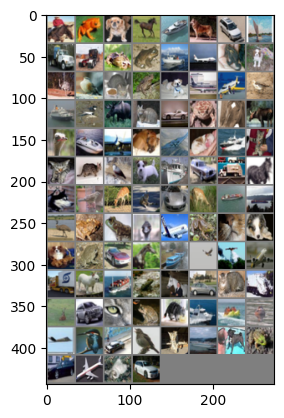

horse frog  dog   horse ship  dog   car   ship  truck truck frog  frog  ship  plane frog  dog   bird  bird  cat   frog  dog   plane plane bird  ship  bird  deer  cat   car   frog  horse deer  bird  ship  plane dog   plane dog   ship  cat   cat   cat   bird  dog   ship  car   truck horse dog   bird  deer  cat   car   deer  ship  ship  bird  frog  frog  bird  plane frog  cat   dog   dog   frog  car   horse ship  bird  plane plane truck dog   ship  frog  horse car   cat   truck deer  car   cat   frog  cat   ship  ship  bird  plane bird  car   bird  cat   ship  dog   frog  car   plane cat   car  


In [11]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [12]:
images.shape

torch.Size([100, 3, 32, 32])

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs.to("cuda"))
        loss = criterion(outputs, labels.to("cuda"))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 2.307
[1,   101] loss: 2.147
[1,   201] loss: 1.815
[1,   301] loss: 1.631
[1,   401] loss: 1.514
[2,     1] loss: 1.420
[2,   101] loss: 1.494
[2,   201] loss: 1.472
[2,   301] loss: 1.349
[2,   401] loss: 1.407
[3,     1] loss: 1.140
[3,   101] loss: 1.167
[3,   201] loss: 1.156
[3,   301] loss: 1.375
[3,   401] loss: 1.452
Finished Training
